In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

In [4]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

# Add labels
fake_df["label"] = 0  # Fake
true_df["label"] = 1  # Real

# Combine datasets
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

# Combine title and text
df["text"] = df["title"] + " " + df["text"]

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Dataset shape:", df.shape)
print(df["label"].value_counts())


Dataset shape: (44898, 5)
label
0    23481
1    21417
Name: count, dtype: int64


In [5]:
def ensure_nltk_resource(resource_name):
    try:
        nltk.data.find(resource_name)
        print(f"✅ '{resource_name}' already available.")
    except LookupError:
        print(f"⬇️  Downloading '{resource_name}'...")
        nltk.download(resource_name.split('/')[-1])

ensure_nltk_resource('corpora/stopwords')
ensure_nltk_resource('corpora/wordnet')
ensure_nltk_resource('corpora/omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

✅ 'corpora/stopwords' already available.
⬇️  Downloading 'corpora/wordnet'...
⬇️  Downloading 'corpora/omw-1.4'...


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\COMPUMARTS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\COMPUMARTS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df["clean_text"] = df["text"].apply(clean_text)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [8]:
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(max_iter=300)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("Accuracy (LR):", accuracy_score(y_test, lr_pred))
print("F1-score (LR):", f1_score(y_test, lr_pred))
print("\nClassification Report (LR):\n", classification_report(y_test, lr_pred))

print("\nTraining Linear SVM...")
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print("Accuracy (SVM):", accuracy_score(y_test, svm_pred))
print("F1-score (SVM):", f1_score(y_test, svm_pred))
print("\nClassification Report (SVM):\n", classification_report(y_test, svm_pred))


Training Logistic Regression...
Accuracy (LR): 0.9869710467706013
F1-score (LR): 0.9863493174658733

Classification Report (LR):
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4710
           1       0.98      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Training Linear SVM...
Accuracy (SVM): 0.9939866369710467
F1-score (SVM): 0.9936827328029949

Classification Report (SVM):
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4710
           1       0.99      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



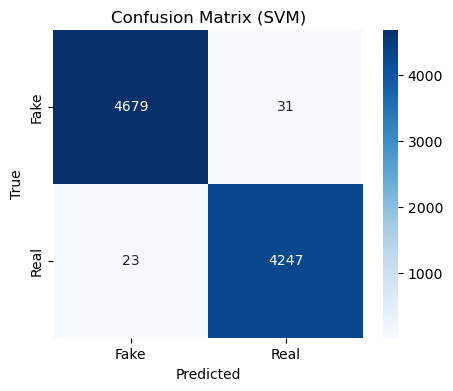

In [9]:
cm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (SVM)")
plt.show()

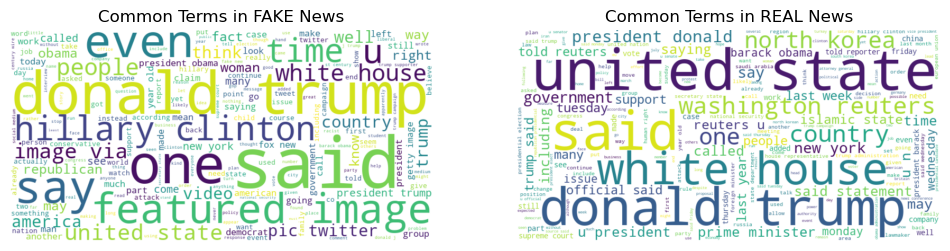

In [10]:
fake_text = " ".join(df[df["label"] == 0]["clean_text"])
real_text = " ".join(df[df["label"] == 1]["clean_text"])

wc_fake = WordCloud(width=800, height=400, background_color="white").generate(fake_text)
wc_real = WordCloud(width=800, height=400, background_color="white").generate(real_text)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(wc_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Common Terms in FAKE News")

plt.subplot(1,2,2)
plt.imshow(wc_real, interpolation="bilinear")
plt.axis("off")
plt.title("Common Terms in REAL News")
plt.show()
